In [29]:
%%time

#Modded from qutip to allow parallelism
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator

def floquet_modes_mod(H, T, args=None, parallel=False, sort=False, U=None):
    """
    Calculate the initial Floquet modes Phi_alpha(0) for a driven system with
    period T.

    Returns a list of :class:`qutip.qobj` instances representing the Floquet
    modes and a list of corresponding quasienergies, sorted by increasing
    quasienergy in the interval [-pi/T, pi/T]. The optional parameter `sort`
    decides if the output is to be sorted in increasing quasienergies or not.

    Parameters
    ----------

    H : :class:`qutip.qobj`
        system Hamiltonian, time-dependent with period `T`

    args : dictionary
        dictionary with variables required to evaluate H

    T : float
        The period of the time-dependence of the hamiltonian. The default value
        'None' indicates that the 'tlist' spans a single period of the driving.

    U : :class:`qutip.qobj`
        The propagator for the time-dependent Hamiltonian with period `T`.
        If U is `None` (default), it will be calculated from the Hamiltonian
        `H` using :func:`qutip.propagator.propagator`.

    Returns
    -------

    output : list of kets, list of quasi energies

        Two lists: the Floquet modes as kets and the quasi energies.

    """
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, parallel=parallel, progressbar=True, options=options)
    
    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 21.2 µs


In [79]:
import numpy as np
import cupy as cp
from qutip import Qobj, propagator

from qutip import basis, jmat

def drive(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.sin(w*t) + h0

def drive_gpu(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * cp.sin(w*t) + h0

def get_hamiltonians(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                      # kacNorm
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1

def propagator_evolve(args):
    N = args['N']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    H0, H1 = get_hamiltonians(N)
    H = [H0,[H1,drive]]
    U = propagator(H, T, [], args, parallel=True, progressbar=False, options=opts)
    U_gpu = cp.array(U.full())
    return U_gpu

def floq_evolv(args):
    N = args['N']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    H0, H1 = get_hamiltonians(N)
    H = [H0,[H1,drive]]
    f_states, _ = floquet_modes_mod(H, T, args=args)
    return f_states

def heating_rate(params, nperiods = 4000):
    umat_gpu = propagator_evolve(params)
    N = params['N']

    H0, H1 = get_hamiltonians(N)
    #t=0 Hamiltonian
    Ht0 = H0 + drive(0, params) * H1
    en, psi0 = Ht0.groundstate()

    psi0_gpu = cp.array(psi0)

    H0_gpu, H1_gpu = cp.array(H0.full()),cp.array(H1.full()) 

    w = params['omega']
    T = 2 * cp.pi/omega
    hbar_data = cp.zeros(nperiods+1, dtype=cp.complex128)
    hsigma_data = cp.zeros_like(hbar_data)

    hbar_data[0] = en

    psi_prev_gpu = psi0_gpu

    for n in cp.arange(1, nperiods+1):
        psiT_gpu = umat_gpu @ psi_prev_gpu
        HT_gpu = H0_gpu + drive_gpu(n*T, params) * H1_gpu
        hbar_gpu = cp.conjugate(psiT_gpu).T @ HT_gpu @ psiT_gpu
        hsqbar_gpu = cp.conjugate(psiT_gpu).T @ HT_gpu @ HT_gpu @ psiT_gpu
        hsigma_gpu = hsqbar_gpu - (hbar_gpu * hbar_gpu)
        hbar_data[n] = hbar_gpu
        hsigma_data[n] = hsigma_gpu
        psi_prev_gpu = psiT_gpu
        
    return hbar_data, hsigma_data   

def get_ipr(params):
    f_states = floq_evolv(params)
    sx = jmat(N,"x")
    en, st = sx.eigenstates()
    ipr = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]
    return ipr

print("Definitions complete!")

Definitions complete!


In [80]:
%%time
#Set parallelization here
nprocs = 6
import qutip
qutip.settings.num_cpus=nprocs

from qutip import Qobj, jmat, Options
import numpy as np
from tqdm import tqdm
from scipy.special import j0, jn_zeros

N = 40
h0 = np.sqrt(3)
omega = 90

freezing_pts = jn_zeros(0, 7)
hroots = freezing_pts * omega/4
h_frz = hroots[5]

not_freezing = 0.5
h_nfrz = not_freezing * omega/4

print("running for N = ", N, "with",nprocs,"processors")  
#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=nprocs, openmp_threads=1)
params_frz = {'h0':h0, 'h':h_frz, 'omega':omega, 'N':N, 'opts':opts}
params_nfrz = {'h0':h0, 'h':h_nfrz, 'omega':omega, 'N':N, 'opts':opts}
avg_frz, sd_frz = heating_rate(params_frz)
ipr_frz = get_ipr(params_frz)
avg_nfrz, sd_nfrz = heating_rate(params_nfrz)
ipr_nfrz = get_ipr(params_nfrz)

running for N =  40 with 6 processors
CPU times: user 12.4 s, sys: 4.36 s, total: 16.8 s
Wall time: 13.2 s


/usr/local/anaconda3/hpc/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 1.0)

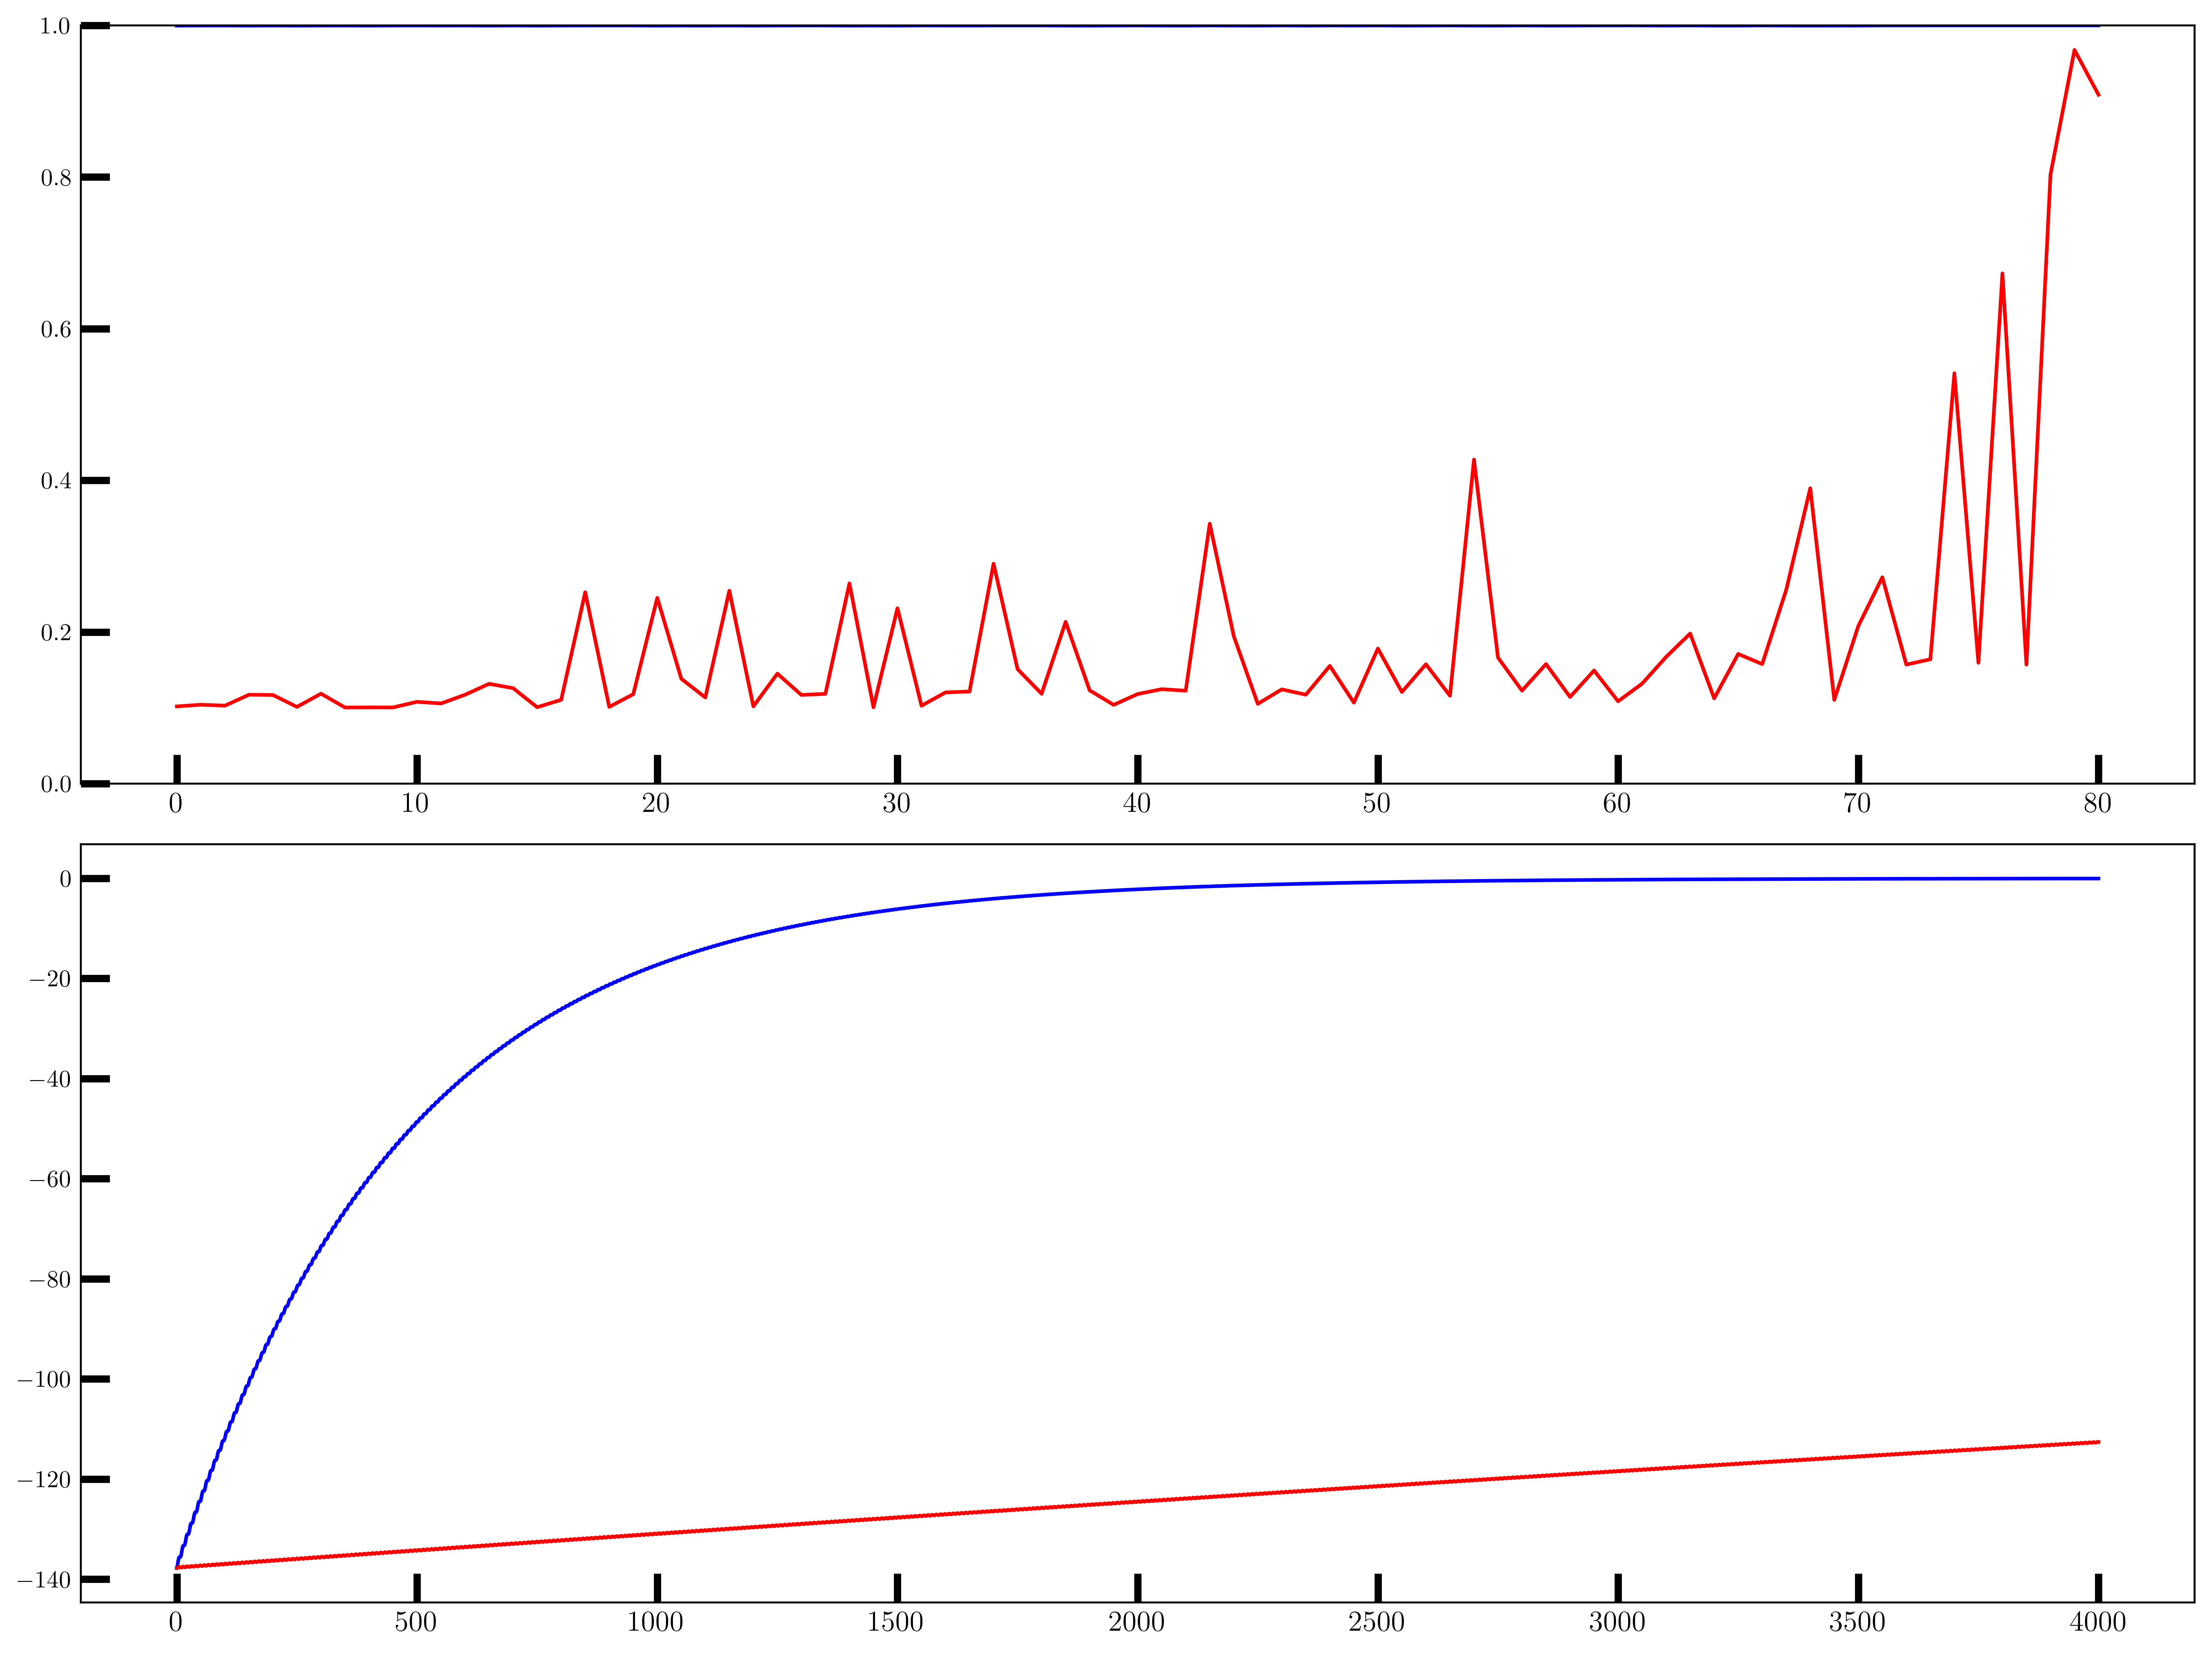

In [81]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1)

axs[0].plot(ipr_frz,'b')
axs[1].plot(avg_frz.get(),'b')
axs[0].plot(ipr_nfrz,'r')
axs[1].plot(avg_nfrz.get(),'r')
axs[0].set_ylim(0.0, 1.0)
